# Librairies

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tensorflow.keras.datasets import imdb
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import sequence
import random

from src.dataset import Dataset
from src.lstm import LSTM

In [ ]:
# Device: GPU if available, CPU else
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import and preprocessing

In [2]:
NUM_WORDS = 5000
INDEX_FROM = 3
TOTAL_LENGTH = 170

# --- Import the IMDB data and only consider the ``top_words``` most used words
np.load.__defaults__=(None, True, True, 'ASCII')
(X, y), (X_test, y_test) = imdb.load_data(num_words=NUM_WORDS, index_from=INDEX_FROM)
np.load.__defaults__=(None, False, True, 'ASCII')

word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X[1000] ))

# --- filter sequences with at least 170 words
X = [lst for lst in X if len(lst) >= TOTAL_LENGTH]
# --- truncate input sequences
X = sequence.pad_sequences(X, maxlen=TOTAL_LENGTH, truncating='post')
# --- Keep only 200 sequences
N = 200
X = X[:N]

print("X shape:", X.shape)
print("len(X[0]):", len(X[0]))
print("len(X[1]):", len(X[1]))
print("X[0]:", X[0])

<START> although i had seen <UNK> in a theater way back in <UNK> i couldn't remember anything of the plot except for vague images of kurt thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending br br after reading some of the other reviews i picked up a copy of the newly released dvd to once again enter the world of <UNK> br br it turns out this is one of those films produced during the <UNK> that would go directly to video today the film stars <UNK> <UNK> kurt thomas as jonathan <UNK> <UNK> out of the blue to <UNK> the nation of <UNK> to enter and hopefully win the game a <UNK> <UNK> <UNK> by the khan who <UNK> his people by yelling what sounds like <UNK> power the goal of the mission involves the star wars defense system jonathan is trained in the martial arts by princess <UNK> who never speaks or leaves the house once trained tries to blend in with the <UNK> by wearing a bright red <UNK> with <UNK> of blue and white needless to say <UNK>

In [3]:
LENGTH_TRAIN = 100
LENGTH_TEST = 70
X_train = X[:, :LENGTH_TRAIN]
X_test = X[:, LENGTH_TRAIN:]

# Train and test LSTM

In [6]:
HIDDEN_SIZE = 64
MODEL_LENGTH = 10
BATCH_SIZE = 1
N_EPOCHS = 5

lstm_model = LSTM(input_size=NUM_WORDS, hidden_size=HIDDEN_SIZE, output_size=NUM_WORDS, model_length=MODEL_LENGTH, batch_size=BATCH_SIZE, device=device)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(lstm_model.parameters())

In [7]:
X_train_torch = torch.tensor(X_train, dtype = torch.long)
X_test_torch = torch.tensor(X_test, dtype = torch.long)

In [8]:
list_perplexity = []
for n in range(N_EPOCHS):
    test_loss = 0
    shuffle_sample = random.sample(range(N), N)
    for i in shuffle_sample:
        # Train LSTM model
        loss_i = 0
        X_train_torch_i = X_train_torch[i]
        x_one_hot_train_i = F.one_hot(X_train_torch_i-1, num_classes=NUM_WORDS).float()
        dataset_i=Dataset(topics=x_one_hot_train_i, model_length=MODEL_LENGTH)
        dataloader_i = DataLoader(dataset_i, batch_size=BATCH_SIZE)
        lstm_model.train_model(dataloader_i, optimizer, criterion)

        for t in range(LENGTH_TEST):
            # Compute p(x_t | x_1:t-1) and perplexity on test sequences
            input_sequence = X_train_torch_i
            input_seq_one_hot = x_one_hot_train_i
            p_next = lstm_model.predict_next_probability(input_seq_one_hot)
            true_x_it_one_hot = F.one_hot(X_test_torch[i][t]-1, num_classes=NUM_WORDS).float()
            cross_entropy = F.cross_entropy(p_next, true_x_it_one_hot, reduction="none").item()
            x_next = torch.multinomial(p_next, 1)+1
            input_sequence = torch.cat([input_sequence, x_next])
            input_seq_one_hot = F.one_hot(input_sequence-1, num_classes=NUM_WORDS).float()
            loss_i+=cross_entropy
        test_loss+=loss_i/LENGTH_TEST     
    mean_test_loss = test_loss/N
    perplexity = np.exp(mean_test_loss)
    print(perplexity)
    list_perplexity.append(perplexity)

C:\Users\yanis\AppData\Local\Temp\ipykernel_143216\2488810157.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_sequence=torch.tensor(self.topics[index:index+self.model_length, :])
C:\Users\yanis\AppData\Local\Temp\ipykernel_143216\2488810157.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_sequence=torch.tensor(self.topics[index+1:index+self.model_length+1, :])


4929.605200047662
4908.216237531931
4905.4120459960595
4905.9568967408595
4904.568143124338


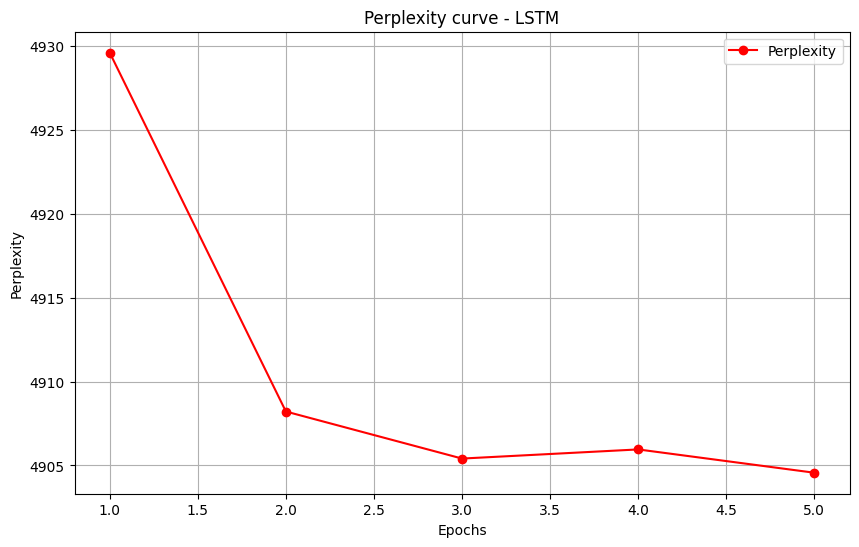

In [13]:
plt.figure(figsize=(10,6))
plt.plot(range(1, N_EPOCHS + 1), list_perplexity, 'o-', color='red', label='Perplexity')
plt.title('Perplexity curve - LSTM')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.grid()
plt.show()